In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import pathlib
import os
from scipy import stats
import seaborn as sns
import anndata as ad
import pathlib
import celltypist
from celltypist import models

from copy import deepcopy
from glob import glob
output_dir='figures/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

In [3]:
adata = sc.read_h5ad('/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/bcells_BCD.h5ad')
adata.obs_names_make_unique(join="_")
cell_cycle_genes = pd.read_table('/home/michaelswift/repos/tabula-bursa/analysis/notebooks/cell_cycle_genes.tab', index_col=0)

In [4]:
%run _helper.py

In [5]:
#adata = adata[adata.obs.donor != 'SBC5.x']

In [6]:
# develop a crude way to label cycling and non-cycling then test features by t-test
same_length = False
genes_contributing_to_score = 30
if same_length:
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:len(cycling), 'cc'], score_name='correlation_cycling')
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:len(cycling), 'anti_cc'], score_name='anticorrelation_cycling')
else:
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:genes_contributing_to_score, 'cc'], score_name='correlation_cycling')
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:genes_contributing_to_score, 'anti_cc'], score_name='anticorrelation_cycling')


adata.obs['corr_cycling'] = adata.obs['correlation_cycling'] > 0.02
adata.obs['anticorr_cycling'] = adata.obs['anticorrelation_cycling'] > 0.4

cycling_mapper = {True:'True', False:'False'}

non_cycling = False
if non_cycling:
    adata.obs['cycling'] = adata.obs['anticorr_cycling'].map(cycling_mapper)
else:
    adata.obs['cycling'] = adata.obs['corr_cycling'].map(cycling_mapper)


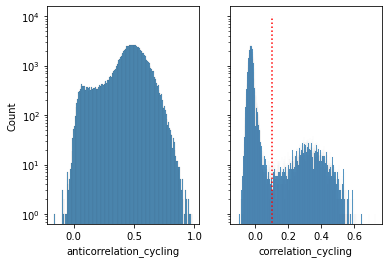

In [12]:
fig, axs = plt.subplots(1,2, sharey=True)
x, y = adata.obs['anticorrelation_cycling'], adata.obs['correlation_cycling']
sns.histplot(x, ax=axs[0])
sns.histplot(y, ax=axs[1])
plt.vlines(x = 0.1, ymax=10000, ymin = 0, linestyles='dotted', color = 'r')
plt.yscale('log')

In [7]:
# remove the dual labels
adata.obs.majority_voting = adata.obs.majority_voting.str.split("|", expand = True).iloc[:,0].astype('category')

... storing 'cycling' as categorical


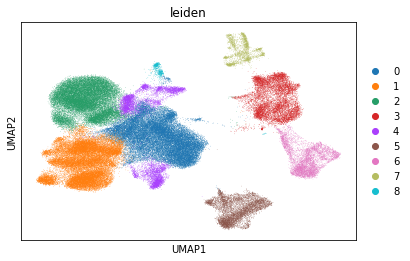

In [8]:
sc.pl.umap(adata, color = 'leiden')

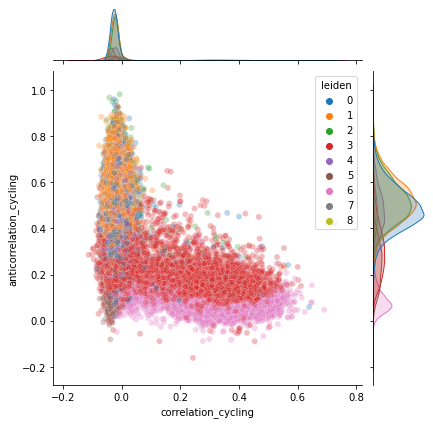

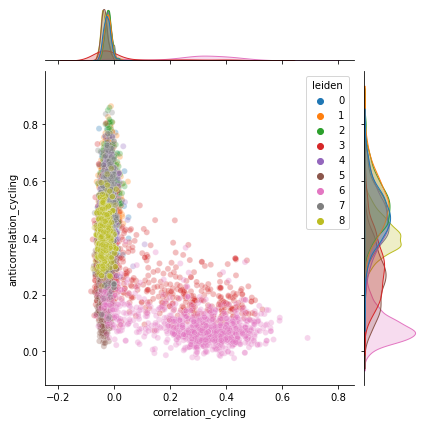

In [13]:
data = adata.obs
x = 'correlation_cycling'
y = 'anticorrelation_cycling'
hue = label
g = sns.jointplot(
        data=data, x=x, y=y, hue=label, kind="scatter", legend=True, alpha=0.3
    )

data = adata.obs
data = data.groupby(label).sample(n=1000, replace=True)
x = 'correlation_cycling'
y = 'anticorrelation_cycling'
g = sns.jointplot(
        data=data, x=x, y=y, hue=label, kind="scatter", legend=True, alpha=0.3
    )

In [17]:
label = 'majority_voting'
label = 'leiden'
adata.obs['cycling_celltype'] = adata.obs.cycling.astype(str) + "_" + adata.obs[label].astype(str)
adata.obs['cycling_celltype'] = adata.obs.cycling_celltype.map(lambda x: 'na' if x.startswith('na') else x)
adata.obs.cyling_celltype = adata.obs.cycling_celltype.astype('category')

cell_group = 'cycling_celltype'
filter_low_abundance_cell_groups = True

# remove the dual labels
adata.obs.majority_voting = adata.obs.majority_voting.str.split("|", expand = True).iloc[:,0].astype('category')
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > 100
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]

adata.obs.loc[:,label] = adata.obs[label].cat.remove_unused_categories()

d = adata.obs.cycling_celltype[adata.obs.cycling == 'True'].str.split("_", expand = True).iloc[:,1].unique()

adata.uns['log1p']['base'] = np.e
marker_genes = {}
rank_genes_groups = {}
for celltype in d:
    sc.tl.rank_genes_groups(adata, groupby='cycling_celltype', method='logreg', reference='False_'+celltype, penalty = 'l2')
    sc.pl.rank_genes_groups(adata, groups=['True_'+celltype])
    marker_genes[celltype] = adata.uns['rank_genes_groups']['names']['True_'+celltype]
    rank_genes_groups[celltype] = adata.uns['rank_genes_groups']

['True_3', 'False_3']
['True_1', 'False_1']
['True_0', 'False_0']
['True_4', 'False_4']
['True_2', 'False_2']
['True_6', 'False_6']


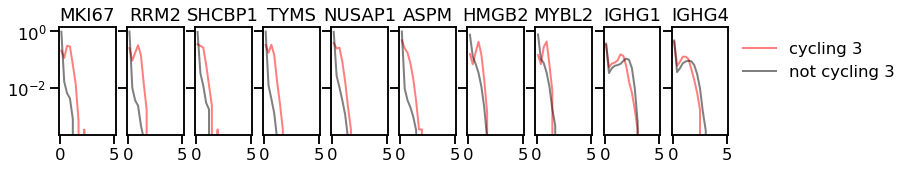

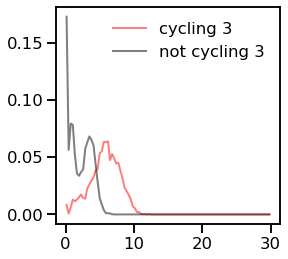

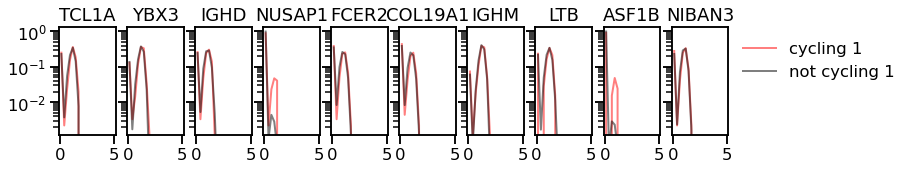

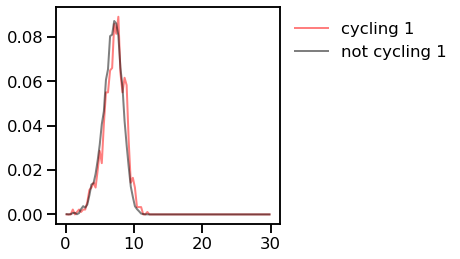

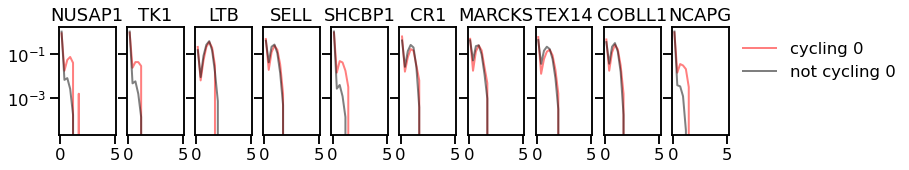

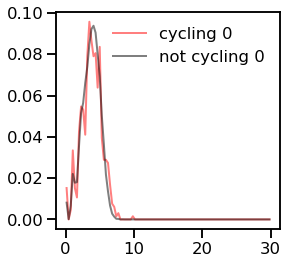

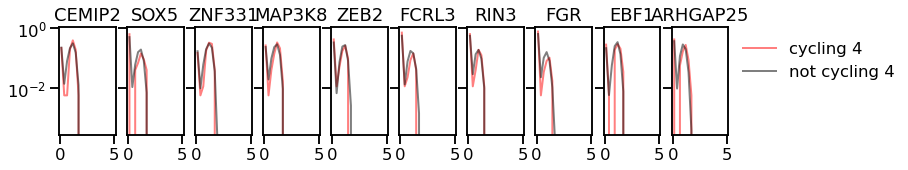

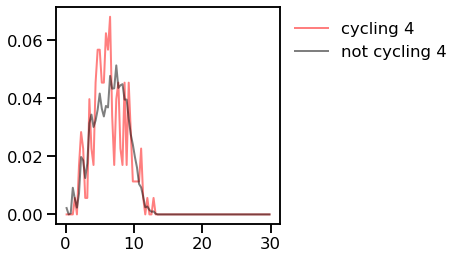

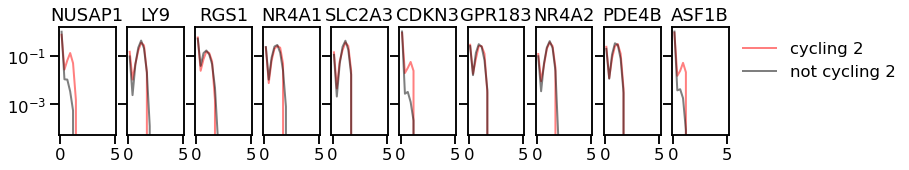

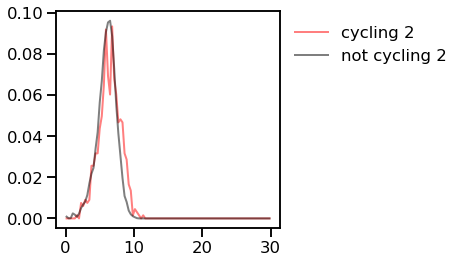

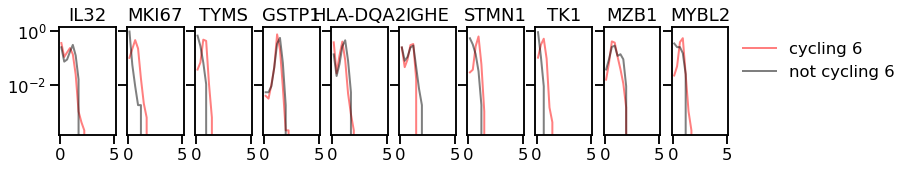

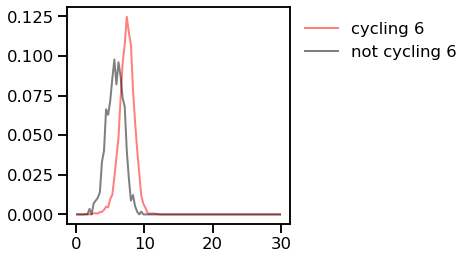

In [28]:
bins = np.linspace(0,5,20)
sum_obs_bins = np.linspace(0,30,100)

bin_centers = (bins[1:] + bins[:-1])/2.
sum_obs_bin_centers = (sum_obs_bins[1:] + sum_obs_bins[:-1])/2.

N_GENES_FOR_CLASSIFIER=100
NGENES = 10
not_cycling_color='k'
cycling_color='r'
color_kwargs = dict(lw=2, alpha=0.5)
all_obs_dfs = {}
for celltype in marker_genes.keys():
    obs_dfs = []
    groups=['True_'+celltype, 'False_'+celltype]
    print(groups)
    fig, ax = plt.subplots(1,NGENES, figsize=(12,2), sharey=True)
    fig_totals, ax_totals = plt.subplots(figsize=(4,4))
    sum_obs=None
    for i, gene in enumerate(marker_genes[celltype][:N_GENES_FOR_CLASSIFIER]):
        obs_df = sc.get.obs_df(adata, gene, use_raw=True)
        if sum_obs is None:
            sum_obs = pd.DataFrame({gene:obs_df})
        else:
            sum_obs = sum_obs.join(pd.DataFrame({gene:obs_df}))
        if i < NGENES:
            ax[i].set_title(gene)

            cycling = obs_df[adata.obs.cycling_celltype==groups[0]]
            not_cycling = obs_df[adata.obs.cycling_celltype==groups[1]]


            counts_cycling, bins = np.histogram(cycling, bins=bins)
            counts_not_cycling, bins = np.histogram(not_cycling, bins=bins)
            ax[i].plot(bin_centers, (counts_cycling)/np.sum(counts_cycling), label='cycling '+celltype,
                      color=cycling_color, **color_kwargs)
            ax[i].plot(bin_centers, (counts_not_cycling)/np.sum(counts_not_cycling), 
                       color = not_cycling_color, label='not cycling '+ celltype, **color_kwargs)
            ax[i].set_yscale('log')
            
    ax[-1].legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
    fig.savefig('figures/{}_cycling_vs_not_cycling_genes.pdf'.format(celltype), bbox_inches='tight')
    i = i+1
    
    obs_dfs.append(sum_obs)
    cycling = sum_obs[adata.obs.cycling_celltype==groups[0]].iloc[:,:NGENES].sum(axis=1)
    not_cycling = sum_obs[adata.obs.cycling_celltype==groups[1]].iloc[:,:NGENES].sum(axis=1)


    counts_cycling, _ = np.histogram(cycling, bins=sum_obs_bins)
    counts_not_cycling, _ = np.histogram(not_cycling, bins=sum_obs_bins)
    ax_totals.plot(sum_obs_bin_centers, (counts_cycling)/np.sum(counts_cycling), label='cycling '+celltype,
              color=cycling_color, **color_kwargs)
    ax_totals.plot(sum_obs_bin_centers, (counts_not_cycling)/np.sum(counts_not_cycling), 
               color = not_cycling_color, label='not cycling '+ celltype, **color_kwargs)
#     ax_totals.set_yscale('log')
    ax_totals.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
    all_obs_dfs.update({celltype: pd.concat(obs_dfs)})

3 8485 943 0.9480381760339343
1 25030 2781 0.974829198130169
0 27524 3058 0.9640287769784173
4 7110 790 0.9632911392405064
2 21514 2391 0.9749058971141782
6 4954 551 0.9891107078039928


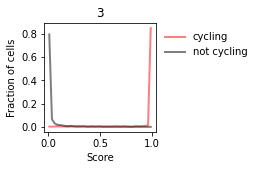

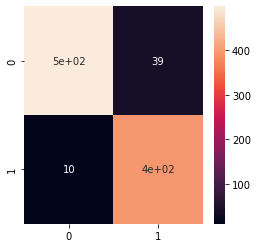

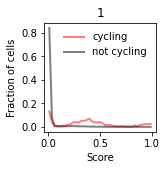

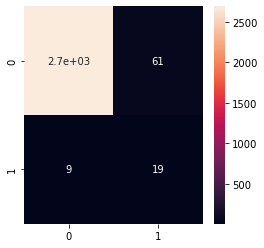

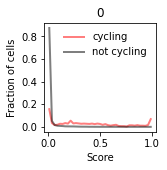

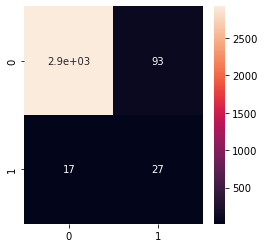

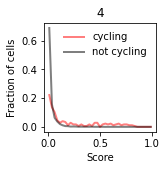

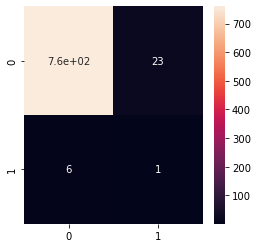

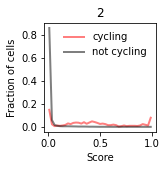

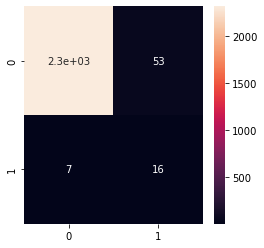

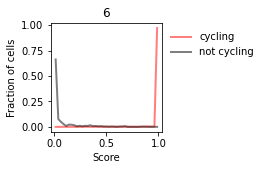

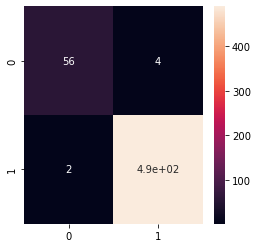

In [22]:
for celltype, obs in all_obs_dfs.items():

    y = adata.obs['cycling']
    obs = obs[adata.obs[label]==celltype]
    y = y[(adata.obs[label]==celltype)] == 'True'
        
    ntrain = round(obs.shape[0]*0.9)
    ntest = obs.shape[0] - ntrain
    
    training = obs.head(ntrain)
    test = obs.tail(ntest)
    training_y = y.head(ntrain)
    test_y = y.tail(ntest)

    clf = LogisticRegression(random_state=0, penalty='l2').fit(training, training_y)
    
    score = clf.score(test, test_y)
    print(celltype, ntrain, ntest, score)
    y_test = clf.predict(test)
    cm = metrics.confusion_matrix(y_test, test_y)
   
    log_probs = clf.predict_log_proba(obs)
    probs = np.exp(log_probs)/(1 + np.exp(log_probs))
    probs = probs.T[1]/(probs.T[0]+probs.T[1])
    
    fig_lr, ax_lr = plt.subplots(figsize=(2,2))
    ax_lr.set_xlabel('Score')
    ax_lr.set_ylabel('Fraction of cells')
    bins = np.linspace(0,1,40)
    bin_centers = (bins[1:]+bins[:-1])/2
    counts_cycling, bins = np.histogram(probs[y], bins=bins)
    counts_not_cycling, bins = np.histogram(probs[~y], bins=bins)
    ax_lr.set_title(celltype)
    ax_lr.plot(bin_centers, (counts_cycling)/np.sum(counts_cycling), label='cycling',
              color=cycling_color, **color_kwargs)
    ax_lr.plot(bin_centers, (counts_not_cycling)/np.sum(counts_not_cycling), 
               color = not_cycling_color, label='not cycling' , **color_kwargs)
    #     ax_totals.set_yscale('log')
    ax_lr.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))    
    fig_lr.savefig('figures/{}_{}_cycling_vs_not_cycling_score.pdf'.format('logreg', celltype), bbox_inches='tight')
    
    
    fig_lr, ax_lr = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True)

In [23]:
sns.set_context('talk')

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

Text(1814.99, 0.5, 'Fraction Non-Cycling')

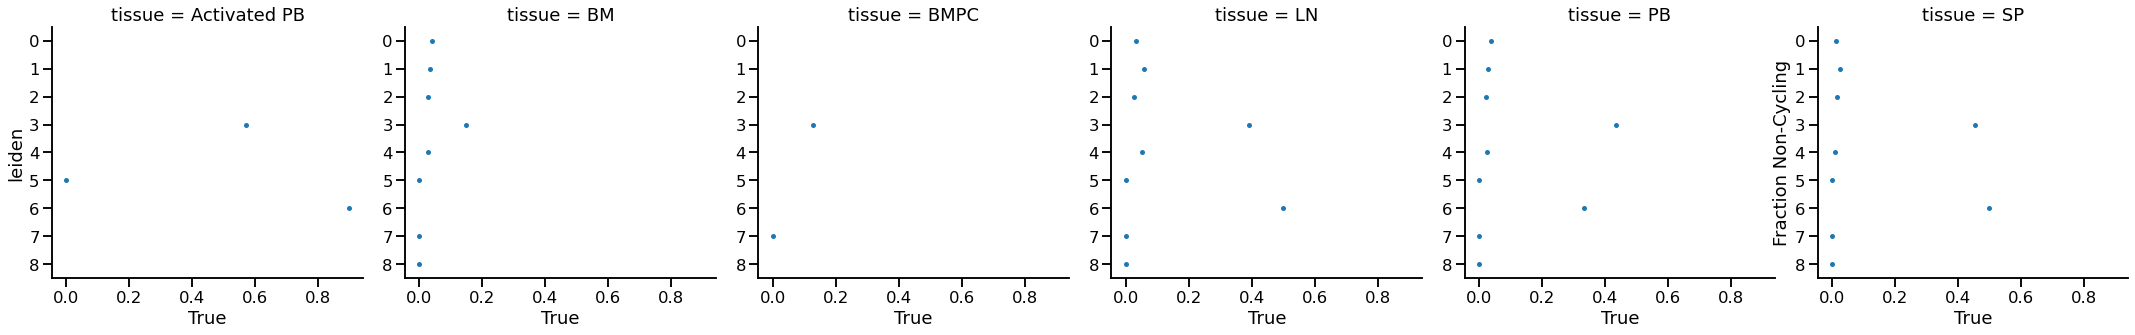

In [24]:
label = 'leiden'
data = adata.obs.groupby([label, 'tissue'])['cycling'].value_counts(normalize = True).unstack()

data = data.reset_index()

sns.catplot(data=data, y = label, x = 'True', col = 'tissue' , sharey=False, )
plt.ylabel('Fraction Non-Cycling')
#plt.yscale('log')

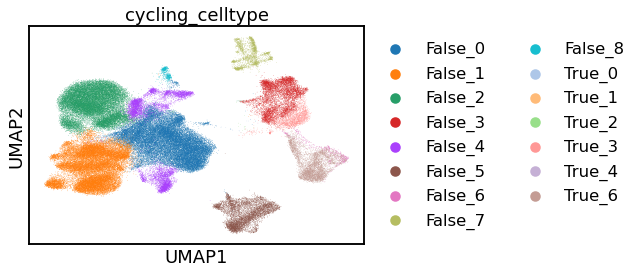

In [30]:
sc.pl.umap(adata, color = 'cycling_celltype')

In [ ]:
label = 'leiden'
data = adata.obs.groupby(label)['cycling'].value_counts(normalize = True).unstack()
data = data.reset_index()
sns.catplot(data=data, y = label, x = 'False')
plt.ylabel(label)
plt.xscale('log')

In [ ]:
label = 'majority_voting'
data = adata.obs.groupby(label)['cycling'].value_counts(normalize = True).unstack()
data = data.reset_index()
sns.catplot(data=data, y = label, x = 'False')
plt.ylabel(label)
plt.xscale('log')

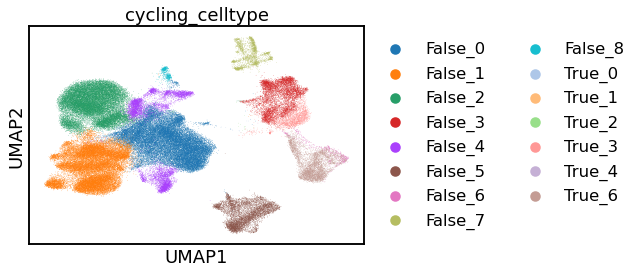

In [34]:
sc.pl.umap(adata, color = 'cycling_celltype')

In [40]:
umap_color_1(adata, 'cycling_celltype', 'True_1', {"size":10})

TypeError: umap_color_1() takes 3 positional arguments but 4 were given

produce a plot for each cell display model predictions and score distributions